# Variational Quantum Eigensolver (VQE) for the Heisenberg Model

This notebook demonstrates the implementation of the Variational Quantum Eigensolver (VQE) using both **hardware-efficient** and **symmetry-preserving ansatz** for the Heisenberg model. The VQE is a hybrid quantum-classical algorithm that estimates the ground and excited states of a quantum system.

We will explore different ansätze circuits, focusing on their resource efficiency and accuracy when computing low-energy eigenstates. This method incorporates symmetries in quantum systems to improve performance, as discussed in the paper.

The VQE algorithm is a promising candidate for achieving quantum advantage in near-term quantum simulators.

In [1]:
!pip install classiq qiskit_qasm3_import pylatexenc -q

In [ ]:
import os
import time
import numpy as np
from PIL import Image
from scipy.linalg import eigh
from qiskit_qasm3_import import parse
from typing import List
from enum import Enum
from dataclasses import dataclass
from classiq import *
import classiq

# Set random seed for reproducibility
np.random.seed(0)
classiq.authenticate(overwrite=True)

## Variational Quantum Eigensolver (VQE)

The **Variational Quantum Eigensolver (VQE)** is a hybrid quantum-classical algorithm that aims to find the ground and excited states of a quantum system. It minimizes the expectation value of a given Hamiltonian 𝐇 using a quantum circuit to generate trial wavefunctions and a classical optimizer to adjust the parameters of the circuit.

In this notebook, we will apply VQE to the **Heisenberg model** and explore both **hardware-efficient** and **symmetry-preserving** ansätze. These methods help reduce the computational overhead required to reach high fidelity results, especially for larger systems.


In [3]:
CONFIG = {} # Later Initialized

## Ansatz Types

The ansatz is a key component of VQE. It defines how we prepare the quantum state by applying quantum gates. We explore two types of ansätze:

1. **Hardware-efficient Ansatz**: A simple structure that applies rotations and entangling gates but does not preserve any symmetry. It's efficient but prone to issues like Barren Plateaus.
2. **Symmetry-preserving Ansatz**: A more complex structure designed to respect the system's physical symmetries, leading to improved performance in preserving energy states.

We define an enum `AnsatzType` to distinguish between these two types in our implementation.

In [4]:
class AnsatzType(Enum):
    """Types of supported ansatz circuits."""
    HARDWARE_EFFICIENT = 'fig-a'           # Hardware-efficient ansatz
    SYMMETRY_PRESERVING_PHASE = 'fig-c'    # Symmetry-preserving ansatz with phase gates
    SYMMETRY_PRESERVING = 'fig-d'          # Symmetry-preserving ansatz without phase gates

## Heisenberg Hamiltonian

We simulate the Heisenberg model for a 1D chain of spin-½ particles using VQE. The Hamiltonian for this system is given by:

$H = J \sum_{i=1}^{N-1} \vec{\sigma}_i \cdot \vec{\sigma}_{i+1}$

Where:
- $J$ is the coupling strength (set to 1 for simplicity),
- $\vec{\sigma}_i = (\sigma^x_i, \sigma^y_i, \sigma^z_i)$ are Pauli matrices acting on the $i$-th qubit.

We will demonstrate how to construct this Hamiltonian using Python and employ VQE to minimize its energy.

In [5]:
class PauliEnum(Enum):
    I = 'I'
    X = 'X'
    Y = 'Y'
    Z = 'Z'

In [6]:
@dataclass
class HamiltonianTerm:
    pauli: List[PauliEnum]
    coefficient: float

    def __repr__(self) -> str:
        return f"HamiltonianTerm(operators={self.pauli}, coupling_strength={self.coefficient})"

def generate_heisenberg_hamiltonian(N: int, J: float) -> QConstant:
    pauli_list: List[HamiltonianTerm] = [
        HamiltonianTerm(
            pauli=[PauliEnum.I] * i + [PauliEnum(pauli.name)] * 2 + [PauliEnum.I] * (N - i - 2),
            coefficient=J
        )
        for i in range(N - 1)
        for pauli in [PauliEnum.X, PauliEnum.Y, PauliEnum.Z]
    ]

    return QConstant(
        "HAMILTONIAN",
        List[PauliTerm],
        [
            PauliTerm(
                pauli=[getattr(Pauli, term.pauli[j].value) for j in range(len(term.pauli))],
                coefficient=term.coefficient
            )
            for term in pauli_list
        ]
    )

In [7]:
def classical_estimation(N, J):
    """
    Calculate the ground state energy of a Heisenberg Hamiltonian using classical computation.
    
    Args:
        N (int): Number of qubits
        J (float): Coupling constant
    
    Returns:
        float: Ground state energy
    """
    pauli_string = HAMILTONIAN.CURRENT_QMODULE.constants['HAMILTONIAN'].value.expr
    
    # Clean up the string to extract individual terms
    terms = pauli_string.strip('[]').split('), ')
    terms = [term + ')' if not term.endswith(')') else term for term in terms]
    
    # Initialize Pauli matrices
    pauli_matrices = {
        'I': np.eye(2),
        'X': np.array([[0, 1], [1, 0]]),
        'Y': np.array([[0, -1j], [1j, 0]]),
        'Z': np.array([[1, 0], [0, -1]])
    }
    
    # Initialize Hamiltonian matrix
    H = np.zeros((2**N, 2**N), dtype=complex)
    
    for term in terms:
        # Extract Pauli operators and coefficient
        pauli_part = term[term.find('['):term.find(']')]
        pauli_operators = [op.split('.')[-1] for op in pauli_part.split(', ') if 'Pauli' in op]
        
        # Extract coefficient
        coeff_start = term.find('coefficient=') + len('coefficient=')
        coefficient = float(term[coeff_start:].rstrip(')'))
        
        # Construct term matrix
        term_matrix = np.eye(1)
        for op in pauli_operators:
            term_matrix = np.kron(term_matrix, pauli_matrices[op])
        
        H += coefficient * term_matrix
    
    # Calculate ground state energy
    eigenvalues = eigh(H, eigvals_only=True)
    return eigenvalues[0]

## Ansatz Circuit Design

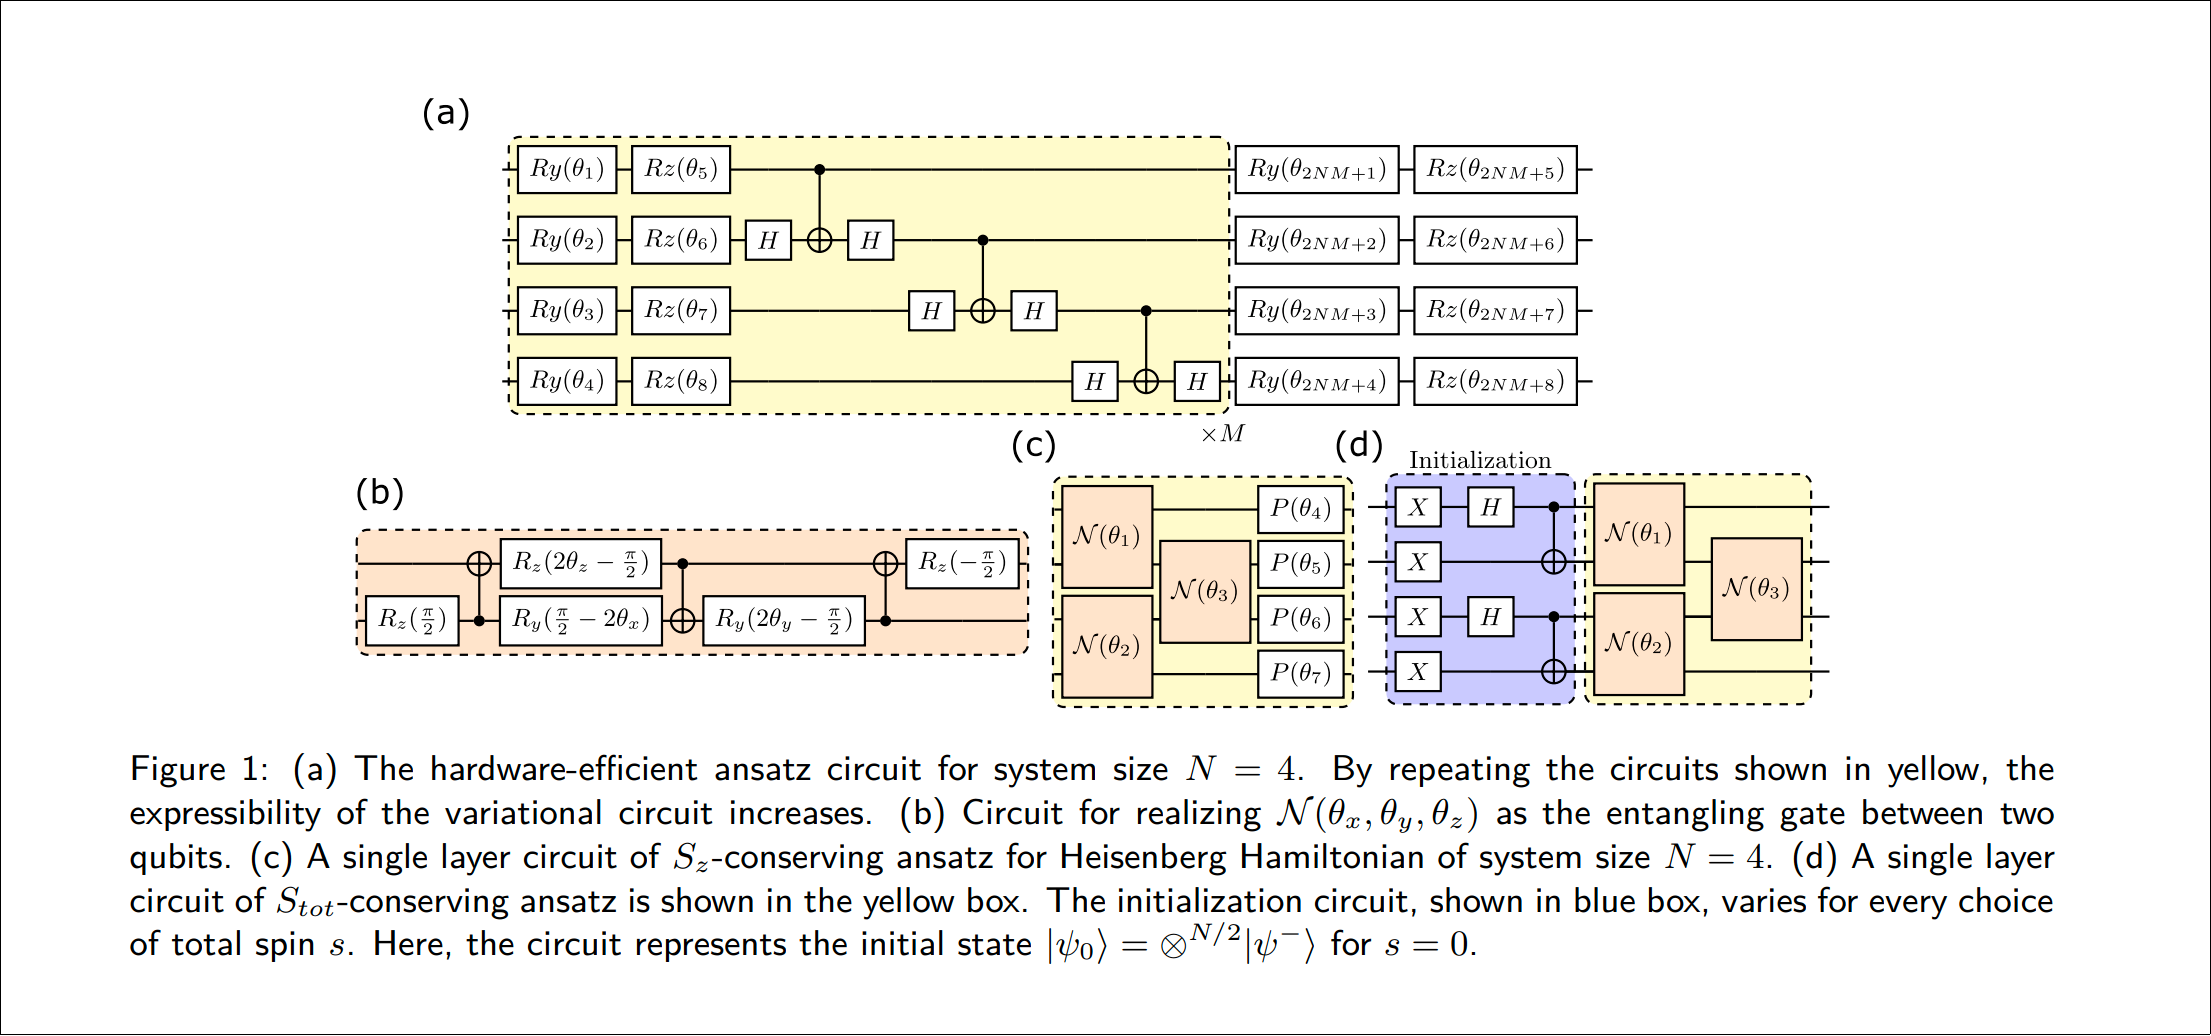

We will now define the quantum circuits (ansätze) used to prepare the quantum states for VQE. There are two main ansätze that we will implement:
1. **Hardware-Efficient Ansatz**:

  - Rotational gates $R_Y$ and $R_Z$ are applied to each qubit followed by entangling gates (CNOTs).

  - This ansatz is straightforward but often suffers from Barren Plateaus, where gradients vanish, making it hard to train deep circuits.

2. **Symmetry-Preserving Ansatz**:

  - Incorporates symmetries from the problem Hamiltonian, such as $S_z$-conservation or total spin $S_{tot}$, to reduce the complexity and the number of parameters required.

  - Symmetry-preserving circuits conserve the number of excitations, which leads to faster convergence.
    
These ansätze are repeated over multiple layers to increase the expressibility of the quantum state.

In [8]:
@qfunc
def apply_hardware_efficient_ansatz(
    qubits: QArray,
    parameters: CArray[CReal]
) -> None:
    """Apply hardware-efficient ansatz with rotations and entanglement."""
    num_qubits = CONFIG['NUM_QUBITS']
    param_idx = 0

    # RY rotations
    for i in range(num_qubits):
        RY(parameters[param_idx], qubits[i])
        param_idx += 1

    # RZ rotations
    for i in range(num_qubits):
        RZ(parameters[param_idx], qubits[i])
        param_idx += 1

    # Entangling layer
    for i in range(num_qubits - 1):
        hadamard_transform(qubits[i + 1])
        CX(qubits[i], qubits[i + 1])
        hadamard_transform(qubits[i + 1])

**Mathematical Justification:**

For the symmetry-preserving ansatz, the following Pauli rotation is applied to ensure symmetry:

$
N(\theta_x, \theta_y, \theta_z) = e^{i(\theta_x \sigma^x_1 \sigma^x_2 + \theta_y \sigma^y_1 \sigma^y_2 + \theta_z \sigma^z_1 \sigma^z_2)}
$

This unitary preserves the number of excitations (i.e., $S_z$) and can be combined with other operators to ensure conservation of total spin $S_{tot}$.

In [9]:
@qfunc
def apply_n_block(
    control: QBit,
    target: QBit,
    theta: CReal
) -> None:
    """Apply N-block pattern for symmetry-preserving ansatz."""
    RZ(np.pi / 2, target)
    CX(target, control)
    RZ(2 * theta - np.pi / 2, control)
    RY(np.pi / 2 - 2 * theta, target)
    CX(control, target)
    RY(2 * theta - np.pi / 2, target)
    CX(target, control)
    RZ(-np.pi / 2, control)

In [10]:
@qfunc
def apply_symmetry_preserving_ansatz(
    qubits: QArray,
    parameters: CArray[CReal],
) -> None:
    """Apply symmetry-preserving ansatz with optional phase gates."""
    param_idx = 0
    num_qubits = CONFIG['NUM_QUBITS']

    # Apply N-blocks in alternating pattern
    for i in range(0, num_qubits, 2):
        apply_n_block(qubits[i], qubits[i+1], parameters[param_idx])
        param_idx += 1

    for i in range(1, num_qubits - 1, 2):
        apply_n_block(qubits[i], qubits[i+1], parameters[param_idx])
        param_idx += 1
    # Optional phase gates
    if CONFIG['ANSATZ_TYPE'] is AnsatzType.SYMMETRY_PRESERVING_PHASE:
        for i in range(num_qubits):
            PHASE(parameters[num_qubits+i-1], qubits[i])

### **Initial State Preparation**

In VQE, the choice of the initial quantum state is essential for efficient convergence. Here, we prepare the initial state depending on the ansatz chosen.

In [11]:
@qfunc
def prepare_initial_state(
    qubits: QArray,
) -> None:
    """Prepare the initial state based on ansatz type."""
    num_qubits = CONFIG['NUM_QUBITS']

    if CONFIG['ANSATZ_TYPE'] in [AnsatzType.HARDWARE_EFFICIENT, AnsatzType.SYMMETRY_PRESERVING_PHASE]:
        for i in range(num_qubits):
            if i % 2 != 0:
                X(qubits[i])
    elif CONFIG['ANSATZ_TYPE'] == AnsatzType.SYMMETRY_PRESERVING:
        for i in range(num_qubits):
            X(qubits[i])
        for i in range(0, num_qubits, 2):
            hadamard_transform(qubits[i])
            CX(qubits[i], qubits[i + 1])

In [12]:
def configure_ansatz_parameters(ansatz_type: AnsatzType) -> None:
    """
    Configure quantum circuit parameters based on the selected ansatz type.

    Args:
        ansatz_type: The type of ansatz to configure (HARDWARE_EFFICIENT,
                    SYMMETRY_PRESERVING_PHASE, or SYMMETRY_PRESERVING)
    """
    global k, LENGTH, INITIAL_STATE, MAX_ITERATIONS, TOLERANCE
    global HAMILTONIAN, STEP_SIZE, SKIP_COMPUTE_VARIANCE, ALPHA_CVAR

    # Update configuration
    CONFIG['ANSATZ_TYPE'] = ansatz_type

    # Define number of parameters based on ansatz type
    k = {
        AnsatzType.HARDWARE_EFFICIENT: CONFIG['NUM_QUBITS'] * 2,
        AnsatzType.SYMMETRY_PRESERVING_PHASE: 2 * CONFIG['NUM_QUBITS'] - 1,
        AnsatzType.SYMMETRY_PRESERVING: CONFIG['NUM_QUBITS'] - 1
    }[ansatz_type]

    LENGTH = k * CONFIG['NUM_LAYERS']

    # Initialize quantum constants  
    INITIAL_STATE = QConstant(
        "INITIAL_STATE",
        List[float],
        list(np.random.rand(LENGTH) - .5)
    )
      
    HAMILTONIAN = generate_heisenberg_hamiltonian(
        CONFIG['NUM_QUBITS'], 
        CONFIG['COUPLING_STRENGTH']
    )

    MAX_ITERATIONS = QConstant(
        "MAX_ITERATIONS",
        int,
        CONFIG['MAX_ITERATIONS']
    )

    TOLERANCE = QConstant(
        "TOLERANCE",
        float,
        CONFIG['TOLERANCE']
    )

    STEP_SIZE = QConstant(
        "STEP_SIZE",
        float,
        CONFIG['STEP_SIZE']
    )

    SKIP_COMPUTE_VARIANCE = QConstant(
        "SKIP_COMPUTE_VARIANCE",
        bool,
        CONFIG['SKIP_COMPUTE_VARIANCE']
    )

    ALPHA_CVAR = QConstant(
        "ALPHA_CVAR",
        float,
        CONFIG['ALPHA_CVAR']
    )

### **VQE Optimization Workflow**

We now optimize the parameters of the ansatz to minimize the energy expectation of the Hamiltonian. The optimization is performed using the **L-BFGS** classical optimizer.

In [13]:
@cfunc
def optimize_vqe() -> None:
    """Run VQE optimization."""
    result = vqe(
        hamiltonian=HAMILTONIAN,
        maximize=False,
        initial_point=INITIAL_STATE,
        optimizer=Optimizer.ADAM,
        max_iteration=MAX_ITERATIONS,
        tolerance=TOLERANCE,
        step_size=STEP_SIZE,
        skip_compute_variance=SKIP_COMPUTE_VARIANCE,
        alpha_cvar=ALPHA_CVAR
    )
    save({"result": result})

In [24]:
def run_vqe(ansatz_type: AnsatzType) -> None:
    """
    Execute the Variational Quantum Eigensolver (VQE) algorithm.

    Prepares quantum circuit based on specified ansatz type, optimizes parameters
    to find ground state energy of target Hamiltonian, and returns minimal energy.

    Args:
        ansatz_type: Type of ansatz circuit to use (hardware efficient or symmetry preserving)
    """
    configure_ansatz_parameters(ansatz_type)
    start_time = time.time()

    @qfunc
    def main(q: Output[QArray], p: CArray[CReal, LENGTH]) -> None:
        num_qubits = CONFIG['NUM_QUBITS']
        num_layers = CONFIG['NUM_LAYERS']

        allocate(num_qubits, q)
        prepare_initial_state(q)

        for i in range(num_layers):
            params = p[i * k:(i + 1) * k]
            if ansatz_type == AnsatzType.HARDWARE_EFFICIENT:
                apply_hardware_efficient_ansatz(q, params)
            else:
                apply_symmetry_preserving_ansatz(q, params)

    qmod = create_model(main, classical_execution_function=optimize_vqe)
    prefs = set_execution_preferences(
        qmod,
        execution.ExecutionPreferences(
            num_shots=CONFIG['NUM_SHOTS'],
            job_name=f"vqe_{ansatz_type.value}_{CONFIG}"
        ),
    )

    os.makedirs(CONFIG['RESULTS_DIR']+f"_{ansatz_type.value}", exist_ok=True)
    file_name = f"{CONFIG['RESULTS_DIR']}_{ansatz_type.value}/vqe_{ansatz_type.value}_{CONFIG['NUM_QUBITS']}_{CONFIG['NUM_LAYERS']}"
    
    qprog = synthesize(prefs) 
    parse(QuantumProgram.from_qprog(qprog).qasm).decompose().draw('mpl').savefig(f"{file_name}_circ.jpg")  
    
    with open(f"{file_name}.qprog", 'w') as text:
        text.write(qprog)

    print("🚀 OPTIMIZATION INITIATED 🚀")

    result = execute(qprog).result()[0]   
    energy = result.value.energy
    print(f"✨ MINIMAL ENERGY OF HAMILTONIAN: {energy} ✨")

    elapsed_time = time.time() - start_time
    print("🔚 OPTIMIZATION COMPLETE 🔚")
    print(f"⏳ TIME TAKEN: {elapsed_time:.2f} seconds ⏳")
   
    result.value.convergence_graph.save(f"{file_name}.jpg")   
    with open(f"{file_name}.json", 'w') as json_file:
        json_file.write(result.model_dump_json(indent=4))
    
    return Image.open(f"{file_name}.jpg")

In [25]:
# Configuration constants
CONFIG = {
    
    'NUM_QUBITS': 4,                # Number of qubits used
    'COUPLING_STRENGTH': 1,         # Strength of interaction between spins
    'NUM_LAYERS': 5,                # Number of layers in the ansatz
    'NUM_SHOTS': 8192,              # Number of measurement shots
    'MAX_ITERATIONS': 10000,        # Maximum number of iterations
    'TOLERANCE': 1e-10,             # Tolerance for the optimizer
    'STEP_SIZE': 20,                # Step size for the optimizer
    'SKIP_COMPUTE_VARIANCE': False, # Skip variance computation
    'ALPHA_CVAR': 1.0               # Alpha value for CVaR optimization    
}

CONFIG['RESULTS_DIR'] = f'''RESULTS/{CONFIG['NUM_QUBITS']}_{CONFIG['NUM_LAYERS']}'''

In [ ]:
# Select Ansatz type from configuration and Run the VQE algorithm
run_vqe(AnsatzType.HARDWARE_EFFICIENT)

In [ ]:
# Select Ansatz type from configuration and Run the VQE algorithm
run_vqe(AnsatzType.SYMMETRY_PRESERVING_PHASE)

In [ ]:
# Select Ansatz type from configuration and Run the VQE algorithm
run_vqe(AnsatzType.SYMMETRY_PRESERVING)

In [ ]:
print(f"✨ MINIMAL ENERGY OF HAMILTONIAN COMPUTED CLASSICALLY: {classical_estimation(CONFIG['NUM_QUBITS'], CONFIG['COUPLING_STRENGTH']):.4f} ✨")

In [20]:
# Configuration constants
CONFIG = {
    'NUM_QUBITS': 4,                # Number of qubits used
    'COUPLING_STRENGTH': 1,         # Strength of interaction between spins
    'NUM_LAYERS': 15,               # Number of layers in the ansatz
    'NUM_SHOTS': 8192,              # Number of measurement shots
    'MAX_ITERATIONS': 10000,        # Maximum number of iterations
    'TOLERANCE': 1e-10,             # Tolerance for the optimizer
    'STEP_SIZE': 20,                # Step size for the optimizer
    'SKIP_COMPUTE_VARIANCE': False, # Skip variance computation
    'ALPHA_CVAR': 1.0               # Alpha value for CVaR optimization
}

CONFIG['RESULTS_DIR'] = f'''RESULTS/{CONFIG['NUM_QUBITS']}_{CONFIG['NUM_LAYERS']}'''

In [ ]:
# Select Ansatz type from configuration and Run the VQE algorithm
run_vqe(AnsatzType.HARDWARE_EFFICIENT)

In [ ]:
# Select Ansatz type from configuration and Run the VQE algorithm
run_vqe(AnsatzType.SYMMETRY_PRESERVING_PHASE)

In [ ]:
# Select Ansatz type from configuration and Run the VQE algorithm
run_vqe(AnsatzType.SYMMETRY_PRESERVING)

In [ ]:
print(f"✨ MINIMAL ENERGY OF HAMILTONIAN COMPUTED CLASSICALLY: {classical_estimation(CONFIG['NUM_QUBITS'], CONFIG['COUPLING_STRENGTH']):.4f} ✨")

## Results and Conclusion

We have successfully implemented the Variational Quantum Eigensolver (VQE) for the Heisenberg model using both hardware-efficient and symmetry-preserving ansätze. The VQE algorithm was able to find the minimal energy of the Hamiltonian, demonstrating the effectiveness of symmetry exploitation in improving the efficiency and accuracy of quantum simulations.

Further extensions of this notebook could include experimenting with different numbers of qubits, analyzing excited state preparation, or applying the method to different Hamiltonians.